# ColorSkim Machine Learning AI



In [373]:
# import modul
import os

# import pandas, numpy dan tensorflow
import pandas as pd
import numpy as np
import tensorflow as tf

# import daftar device terdeteksi oleh tensorflow
from tensorflow.python.client.device_lib import list_local_devices

# import utilitas umum tensorflow
from tensorflow.config import run_functions_eagerly # type: ignore
from tensorflow.data.experimental import enable_debug_mode # type: ignore

# import pembuatan dataset
from sklearn.model_selection import train_test_split
from_tensor_slices = tf.data.Dataset.from_tensor_slices

# import preprocessing data
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# import pipeline scikit untuk model_0
from sklearn.pipeline import Pipeline

# import layer neural network
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.layers import Input, Conv1D, Dense, GlobalMaxPooling1D# type: ignore
from tensorflow.keras.layers import TextVectorization # type: ignore
from tensorflow.keras.layers import Embedding # type: ignore

# import fungsi loss dan optimizer
from tensorflow.keras.losses import BinaryCrossentropy # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

# import model Functional API tensorflow
from tensorflow.keras import Model # type: ignore

# import callbacks untuk tensorflow
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # type: ignore

# import metriks dan alat evaluasi
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# import grafik
import matplotlib.pyplot as plt
import seaborn as sns

# import display untuk menampilkan dataframe berdasar settingan tertentu (situasional)
from IPython.display import display

# import library log untuk training
import wandb as wb
from wandb.keras import WandbCallback

# import kunci untuk login wandb
from rahasia import API_KEY_WANDB # type: ignore

# set output tensorflow
run_functions_eagerly(True)
enable_debug_mode()

# set matplotlib untuk menggunakan tampilan seaborn
sns.set()

In [2]:
# cek ketersediaan GPU untuk modeling
# NVidia GeForce MX250 - office
# NVidia GeForce GTX1060 - home
list_local_devices()[1]

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1408103015
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4056498819655542482
physical_device_desc: "device: 0, name: NVIDIA GeForce MX250, pci bus id: 0000:02:00.0, compute capability: 6.1"
xla_global_id: 416903419

## Variabel Global

In [377]:
DIR_MODEL_CHECKPOINT = 'colorskim_checkpoint'
# kita akan mengatur toleransi_es sebagai fraksi (fraksi_toleransi) tertentu dari jumlah total epoch
# dan toleransi_rlop sebagai toleransi_es dibagi dengan jumlah kesempatan (kesempatan_rlop)
# dilakukannya reduksi pada learning_rate 
EPOCHS = 1000
UKURAN_BATCH = 64
FRAKSI_TOLERANSI = 0.2
KESEMPATAN_RLOP = 4
TOLERANSI_ES = int(EPOCHS*FRAKSI_TOLERANSI)
TOLERANSI_RLOP = int(TOLERANSI_ES/KESEMPATAN_RLOP)
FRAKSI_REDUKSI_LR = 0.1
RANDOM_STATE = 11
RASIO_TEST_TRAIN = 0.2

# wandb init
wandb = {'proyek': 'ColorSkim',
         'user': 'jpao'}

## Callbacks

Beberapa *callbacks* yang akan digunakan dalam proses *training* model diantaranya:
* `WandbCallback` - *Callback* ke [wandb.ai](https://wandb.ai) untuk mencatat log dari sesi *training* model.
* `ModelCheckpoint` - Untuk menyimpan model dengan *val_loss* terbaik dari seluruh *epoch* dalam *training* model.
* `EarlyStopping` (ES) - *Callback* ini digunakan untuk menghentikan proses *training* model jika selama beberapa *epoch* model tidak mengalami perbaikan pada metrik *val_loss*-nya. *Callback* ini juga digunakan bersama dengan `ReduceLROnPlateau` dimana *patience* ES > *patience* RLOP.
* `ReduceLROnPlateau` (RLOP) - *Callback* ini digunakan untuk memperkecil *learning_rate* dari model jika tidak mengalami perbaikan *val_loss* selama beberapa *epoch*.

*Patience* dari ES di-set lebih tinggi dari *patience* RLOP untuk memberikan kesempatan bagi RLOP untuk memperkecil *learning_rate* beberapa kali sebelum proses *training* model dihentikan oleh ES setelah tidak berhasil mendapatkan *val_loss* yang lebih baik selama beberapa *epoch*.

In [4]:
# login ke wandb
wb.login(key=API_KEY_WANDB)

# Pembuatan fungsi callback
def wandb_callback():
    return WandbCallback(save_model=False, # model akan disimpan menggunakan callback ModelCheckpoint
                         log_weights=True, # weight akan disimpan untuk visualisasi di wandb
                         log_gradients=True) # gradient akan disimpan untuk visualisasi di wandb
def model_checkpoint(nama_model):
    return ModelCheckpoint(filepath=os.path.join(DIR_MODEL_CHECKPOINT, nama_model),
                           verbose=0,
                           save_best_only=True) # model dengan 'val_loss' terbaik akan disimpan
def early_stopping():
    return EarlyStopping(patience=TOLERANSI_ES)
def reduce_lr_on_plateau():
    return ReduceLROnPlateau(factor=FRAKSI_REDUKSI_LR, # pengurangan learning_rate diset sebesar 0.1 * learning_rate
                             patience=TOLERANSI_RLOP,
                             verbose=0)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jpao (pri-data). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\jPao/.netrc


## Data

Data yang dipergunakan adalah sebanyak 101,077 kata. Terdapat 2 versi data, data versi 1 hanya memiliki 56,751 kata dan data versi 2 adalah data lengkap.
* Data 1: 56,751 kata, terdiri dari 34,174 kata dengan label `bukan_warna` dan 22,577 kata dengan label `warna` atau rasio 1.51 : 1 `bukan_warna` berbanding `warna`
* Data 2: 101,077 kata, rincian menyusul....

`brand`, `urut_kata` dan `total_kata` akan digunakan sebagai alternatif variabel independen tambahan dalam model tertentu.

In [147]:
# Membaca data ke dalam DataFrame pandas
# Merubah kolom `urut_kata` dan 'total_kata' menjadi float32
data = pd.read_csv('data/setengah_dataset_artikel.csv')
data = data.astype({'urut_kata': np.float32, 'total_kata': np.float32})
data

,brand,nama_artikel,kata,label,urut_kata,total_kata
0,ADI,ADISSAGE-BLACK/BLACK/RUNWHT,ADISSAGE,bukan_warna,1.0,4.0
1,ADI,ADISSAGE-BLACK/BLACK/RUNWHT,BLACK,warna,2.0,4.0
2,ADI,ADISSAGE-BLACK/BLACK/RUNWHT,BLACK,warna,3.0,4.0
3,ADI,ADISSAGE-BLACK/BLACK/RUNWHT,RUNWHT,warna,4.0,4.0
4,ADI,ADISSAGE-N.NAVY/N.NAVY/RUNWHT,ADISSAGE,bukan_warna,1.0,4.0
...,...,...,...,...,...,...
56746,WAR,125CM PAISLEY WHITE FLAT,PAISLEY,warna,2.0,4.0
56747,WAR,125CM PAISLEY WHITE FLAT,WHITE,warna,3.0,4.0
56748,WAR,125CM VINTAGE ORANGE,125CM,bukan_warna,1.0,3.0
56749,WAR,125CM VINTAGE ORANGE,VINTAGE,warna,2.0,3.0


### Eksplorasi Data

bukan_warna    34174
warna          22577
Name: label, dtype: int64


<AxesSubplot:>

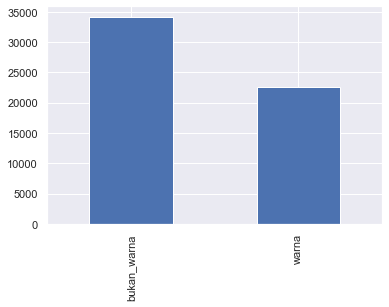

In [65]:
# distribusi label dalam data
print(data['label'].value_counts())
data['label'].value_counts().plot(kind='bar')

label  bukan_warna    warna
brand                      
NIK        13396.0  10807.0
ADI        10028.0   7073.0
PUM         4279.0   2062.0
BBC         1174.0    367.0
CAO          887.0     61.0
HER          868.0    287.0
AGL          611.0    212.0
KIP          554.0    321.0
STN          494.0    255.0
WAR          404.0    298.0


<AxesSubplot:xlabel='brand'>

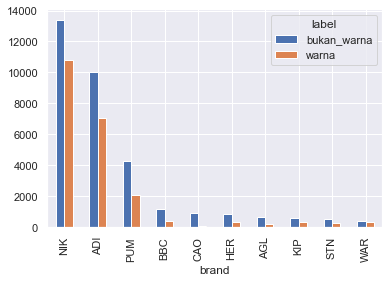

In [67]:
# distribusi label dalam brand (data hanya menunjukkan 10 teratas)
print(data[['brand', 'label']].value_counts().unstack().sort_values(by='bukan_warna', ascending=False)[:10])
data[['brand', 'label']].value_counts().unstack().sort_values(by='bukan_warna', ascending=False)[:10].plot(kind='bar')

### Konversi Fitur dan Label ke dalam numerik

Kita akan melakukan pengkonversian fitur dan label ke dalam bentuk numerik, dikarenakan jaringan saraf buatan hanya dapat bekerja dalam data numerik. 

Terdapat dua jenis *encoding* untuk data yang bersifat kategorikal:
* `OneHotEncoder`
* `LabelEncoder`

**OneHotEncoder**
*Encoding* ini akan merubah data satu kolom menjadi multi-kolom dengan nilai 1 dan 0 dimana jumlah kolom sama dengan jumlah kategori, seperti berikut:
| brand | brand_NIK | brand_ADI | brand_SPE | brand_PIE | brand_... |
| --- | --- | --- | --- | --- | --- |
| NIK | 1 | 0 | 0 | 0 | ... |
| SPE | 0 | 0 | 1 | 0 | ... |
| PIE | 0 | 0 | 0 | 1 | ... |
| ADI | 0 | 1 | 0 | 0 | ... |
| SPE | 0 | 0 | 1 | 0 | ... |
| ... | ... | ... | ... | ... | ... |

**LabelEncoder**
*Encoding* ini akan merubah data pada satu kolom menjadi 0, 1, 2, 3.. dstnya sesuai dengan jumlah kategorinya, seperti berikut:
| brand | brand_label_encoded |
| --- | --- |
| NIK | 0 |
| SPE | 1 |
| PIE | 2 |
| ADI | 3 |
| SPE | 1 |
| ... | ... |

**Kapan menggunakan `OneHotEncoder` atau `LabelEncoder` dalam sebuah proses encoding?** Kita dapat menggunakan `OneHotEncoder` ketika kita tidak menginginkan suatu bentuk hubungan hirarki di dalam data kategorikal yang kita miliki. Dalam hal ini ketika kita tidak ingin jaringan saraf buatan untuk memandang ADI (3) lebih signifikan dari NIK (0) dalam hal nilainya jika dilakukan label *encoding*, maka kita dapat menggunakan `OneHotEncoder`.
Jika kategori bersifat biner seperti 'Pria' atau 'Wanita', 'Ya' atau 'Tidak' dsbnya, penggunaan `LabelEncoder` dinilai lebih efektif.

> Dengan pertimbangan di atas dan melihat struktur data kita, maka kita akan menggunakan `OneHotEncoder` untuk kolom *brand* (fitur) dan menggunakan `LabelEncoder` untuk kolom *label* (target), kecuali untuk **Model 0** yang akan menggunakan fungsi ekstraksi fitur dengan `TfIdfVectorizer` kita hanya akan menggunakan kolom 'label' yang belum di-*encode*.

In [148]:
# OneHotEncoding pada fitur brand
fitur_encoder = OneHotEncoder(sparse=False)
brand_encoded = fitur_encoder.fit_transform(data['brand'].to_numpy().reshape(-1, 1))
df_fitur_encoded = pd.DataFrame(brand_encoded, columns=fitur_encoder.get_feature_names_out(['brand']))

# LabelEncoding pada target label
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(data['label'])
df_label_encoded = pd.DataFrame(label_encoded, columns=['label_encoded'])

# gabungkan dengan dataframe awal
data_encoded = data.copy()
data_encoded = pd.concat([data_encoded,df_fitur_encoded, df_label_encoded], axis=1)
data_encoded

,brand,nama_artikel,kata,label,urut_kata,total_kata,brand_ADI,brand_ADS,brand_AGL,brand_AND,...,brand_PTG,brand_PUM,brand_REL,brand_SAU,brand_SOC,brand_STN,brand_UME,brand_VAP,brand_WAR,label_encoded
0,ADI,ADISSAGE-BLACK/BLACK/RUNWHT,ADISSAGE,bukan_warna,1.0,4.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,ADI,ADISSAGE-BLACK/BLACK/RUNWHT,BLACK,warna,2.0,4.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,ADI,ADISSAGE-BLACK/BLACK/RUNWHT,BLACK,warna,3.0,4.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,ADI,ADISSAGE-BLACK/BLACK/RUNWHT,RUNWHT,warna,4.0,4.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,ADI,ADISSAGE-N.NAVY/N.NAVY/RUNWHT,ADISSAGE,bukan_warna,1.0,4.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56746,WAR,125CM PAISLEY WHITE FLAT,PAISLEY,warna,2.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
56747,WAR,125CM PAISLEY WHITE FLAT,WHITE,warna,3.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
56748,WAR,125CM VINTAGE ORANGE,125CM,bukan_warna,1.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
56749,WAR,125CM VINTAGE ORANGE,VINTAGE,warna,2.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


### Konversi Data ke dalam Train dan Test untuk Model 0

Data akan dibagi ke dalam train dan test data menggunakan metode `train_test_split` dari modul *sklearn.model_selection* dengan menggunakan rasio dan keacakan yang telah ditentukan di variabel global (lihat *RASIO_TEST_TRAIN* dan *RANDOM_STATE*).

In [233]:
# Menyimpan header data
data_header = data_encoded[['kata', 'brand', 'urut_kata', 'total_kata', 'label']].columns

# Model 0 adalah MultinomialNB yang akan menggunakan feature_extraction TfIdfVectorizer
# dimana TfIdfVectorizer hanya dapat menerima satu kolom data yang akan diubah menjadi vector
# (angka), kecuali kita dapat menggabungkan kembali brand kata dan kolom kolom lainnya ke dalam
# satu kolom seperti['NIK GREEN 1 0 0 0 1'] alih - alih [['NIK', 'GREEN', '1', '0', '0', '0', '1']]
# Maka untuk Model 0 kita tetap akan hanya menggunakan kolom 'kata' sebagai fitur.
# kolom 'brand', 'urut_kata' 'total_kata' dan 'label' sebenarnya tidak akan 
# digunakan untuk training, namun pada train_test_split ini kita akan menyimpan brand untuk 
# display hasil prediksi berbanding dengan target label (ground truth)
train_data_mnb, test_data_mnb, train_target_mnb, test_target_mnb = train_test_split(data_encoded[['kata', 'brand', 'urut_kata', 'total_kata', 'label']],
                                                                                    data_encoded['label_encoded'],
                                                                                    test_size=RASIO_TEST_TRAIN,
                                                                                    random_state=RANDOM_STATE)

# Untuk model lainnya kita akan menggunakan semua fitur minus 'brand', 'nama_artikel', 'label' dan 'label_encoded' .drop
train_data, test_data, train_target, test_target = train_test_split(data_encoded.drop(['brand', 'nama_artikel', 'label', 'label_encoded'], axis=1),
                                                                    data_encoded['label_encoded'],
                                                                    test_size=RASIO_TEST_TRAIN,
                                                                    random_state=RANDOM_STATE)

In [247]:
# Eksplorasi contoh hasil split train dan test
train_target_unik, train_target_hitung = np.unique(train_target_mnb, return_counts=True)
test_target_unik, test_target_hitung = np.unique(test_target_mnb, return_counts=True)
print(f'2 data pertama di train_data_mnb:\n{train_data_mnb.iloc[:2, 0].tolist()}\n') # :2 menampilkan 2 data pertama, :1 hanya menampilkan kata
print(f'2 data pertama di train_data:')
with pd.option_context('display.max_columns', None):
    display(train_data[:2])
print(f'\n2 label pertama di train_target (mnb & non-mnb, sama):\n{train_target[:2].tolist()}\n') 
print(f'2 data pertama di test_data_mnb:\n{test_data_mnb.iloc[:2, 0].tolist()}\n') # :2 menampilkan 2 data pertama, :1 hanya menampilkan kata
print(f'2 data pertama di test_data:')
with pd.option_context('display.max_columns', None):
    display(test_data[:2])
print(f'2 label pertama di test_target (mnb & non-mnb, sama):\n{test_target[:2].tolist()}\n')
train_target_distribusi = np.column_stack((train_target_unik, train_target_hitung))
test_target_distribusi = np.column_stack((test_target_unik, test_target_hitung))
print(f'Distribusi label (target) di train: \n{train_target_distribusi}\n')
print(f'Distribusi label (target) di test: \n{test_target_distribusi}\n')
print('Dimana label 0 = bukan warna dan label 1 = warna')

2 data pertama di train_data_mnb:
['GREY', 'BLACK']

2 data pertama di train_data:


,kata,urut_kata,total_kata,brand_ADI,brand_ADS,brand_AGL,brand_AND,brand_ASC,brand_BAL,brand_BBC,brand_BEA,brand_CAO,brand_CIT,brand_CRP,brand_DOM,brand_FIS,brand_GUE,brand_HER,brand_JAS,brand_KIP,brand_NEW,brand_NFA,brand_NFC,brand_NFL,brand_NIB,brand_NIC,brand_NIK,brand_NPS,brand_ODD,brand_PBY,brand_PSB,brand_PTG,brand_PUM,brand_REL,brand_SAU,brand_SOC,brand_STN,brand_UME,brand_VAP,brand_WAR
43886,GREY,12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14859,BLACK,4.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



2 label pertama di train_target (mnb & non-mnb, sama):
[1, 1]

2 data pertama di test_data_mnb:
['SESOYE', 'GHOST']

2 data pertama di test_data:


,kata,urut_kata,total_kata,brand_ADI,brand_ADS,brand_AGL,brand_AND,brand_ASC,brand_BAL,brand_BBC,brand_BEA,brand_CAO,brand_CIT,brand_CRP,brand_DOM,brand_FIS,brand_GUE,brand_HER,brand_JAS,brand_KIP,brand_NEW,brand_NFA,brand_NFC,brand_NFL,brand_NIB,brand_NIC,brand_NIK,brand_NPS,brand_ODD,brand_PBY,brand_PSB,brand_PTG,brand_PUM,brand_REL,brand_SAU,brand_SOC,brand_STN,brand_UME,brand_VAP,brand_WAR
16829,SESOYE,5.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5081,GHOST,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2 label pertama di test_target (mnb & non-mnb, sama):
[1, 0]

Distribusi label (target) di train: 
[[    0 27355]
 [    1 18045]]

Distribusi label (target) di test: 
[[   0 6819]
 [   1 4532]]

Dimana label 0 = bukan warna dan label 1 = warna


## Model 0: Model Dasar

Model pertama yang akan kita buat adalah model *Multinomial Naive-Bayes* yang akan mengkategorisasikan *input* ke dalam kategori *output*. *Multinomial Naive-Bayes* adalah sebuah algoritma dengan metode *supervised learning* yang paling umum digunakan dalam pengkategorisasian data tekstual.
Pada dasarnya *Naive-Bayes* merupakan algoritma yang menghitung probabilitas dari sebuah event (*output*) berdasarkan probabilitas akumulatif kejadian dari event sebelumnya. Secara singkat algoritma ini akan mempelajari berapa probabilitas dari sebuah kata, misalkan 'ADISSAGE' adalah sebuah label `bukan_warna` berdasarkan probabilitas kejadian 'ADISSAGE' adalah `bukan_warna` pada event - event sebelumnya.

Formula dari probabilitias algoritma *Naive-Bayes*:

$P(A|B) = \frac{P(A) * P(B|A)}{P(B)}$

Sebelum melakukan training menggunakan algoritma *Multinomial Naive-Bayes* kita perlu untuk merubah data kata menjadi bentuk numerik yang kali ini akan dikonversi menggunakan metode TF-IDF (*Term Frequency-Inverse Document Frequency*). TF-IDF sendiri merupakan metode yang akan berusaha memvaluasi nilai relevansi dan frekuensi dari sebuah kata dalam sekumpulan dokumen. *Term Frequency* merujuk pada seberapa sering sebuah kata muncul dalam 1 dokumen, sedangkan *Inverse Document Frequency* adalah perhitungan logaritma dari jumlah seluruh dokumen dibagi dengan jumlah dokumen dengan kata yang dimaksud terdapat di dalamnya. Hasil perhitungan dari TF dan IDF ini akan dikalikan untuk mendapatkan nilai dari seberapa sering dan seberapa relevan nilai dari sebuah kata. Misalkan 'ADISSAGE' sering muncul dalam 1 dokumen tapi tidak terlalu banyak muncul di dokumen - dokumen lainnya, maka hal ini dapat mengindikasikan bahwa kata 'ADISSAGE' mungkin memiliki relevansi yang tinggi dalam kategorisasi sebuah dokumen, sebaliknya jika kata 'WHITE' sering muncul di 1 dokumen dan juga sering muncul di dokumen - dokumen lainnya, maka kata 'WHITE' ini mungkin merupakan sebuah kata yang umum dan memiliki nilai relevansi yang rendah dalam pengkategorisasian sebuah dokumen.

Untuk lebih lengkapnya mengenai *Naive-Bayes* dan TF-IDF dapat merujuk pada sumber berikut:
* https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c
* https://monkeylearn.com/blog/what-is-tf-idf/


In [260]:
# Membuat pipeline untuk mengubah kata ke dalam tf-idf
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit pipeline dengan data training
model_0.fit(X=np.squeeze(train_data_mnb.iloc[:, 0]), y=train_target_mnb)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [261]:
# Evaluasi model_0 pada data test
skor_model_0 = model_0.score(X=np.squeeze(test_data_mnb.iloc[:, 0]), y=test_target_mnb)
skor_model_0

0.9921592811206061

### Eksplorasi Hasil Model 0
Pada hasil training dengan menggunakan model algoritma *Multinomial Naive-Bayes* kita mendapatkan akurasi sebesar ~99.22%

Secara sekilas model yang pertama ini (model 0) memberikan akurasi yang sangat tinggi dalam membedakan kata `warna` dan `bukan_warna`. Namun secara brand speisifik, akurasi ini mungkin akan lebih buruk karena di beberapa brand terutama 'PUM' kita dapat menjumpai artikel dengan nama misalkan 'PUMA XTG WOVEN PANTS PUMA BLACK-PUMA WHITE' dimana kata PUMA pertama adalah `bukan_warna` namun kata PUMA kedua dan ketiga adalah bagian dari `warna`.

Dengan demikian, nanti kita mungkin akan mengulas lebih mendalam model pertama ini menggunakan dataset yang dipisahkan berdasar brand. Untuk sementara kita akan melanjutkan mengembangkan model - model alternatif untuk pemisahan `bukan_warna` dan `warna` dari nama artikel.

In [262]:
# Membuat prediksi menggunakan data test
pred_model_0 = model_0.predict(np.squeeze(test_data_mnb.iloc[:, 0]))
pred_model_0

array([1, 0, 1, ..., 0, 0, 0])

In [153]:
# Membuat fungsi dasar untuk menghitung accuray, precision, recall, f1-score
def hitung_metrik(target, prediksi):
    """
    Menghitung accuracy, precision, recall dan f1-score dari model klasifikasi biner
    
    Args:
        target: label yang sebenarnya dalam bentuk 1D array
        prediksi: label yang diprediksi dalam bentuk 1D array
        
    Returns:
        nilai accuracy, precision, recall dan f1-score dalam bentuk dictionary
    """
    # Menghitung akurasi model
    model_akurasi = accuracy_score(target, prediksi)
    # Menghitung precision, recall, f1-score dan support dari model
    model_presisi, model_recall, model_f1, _ = precision_recall_fscore_support(target, prediksi, average='weighted')
    
    hasil_model = {'akurasi': model_akurasi,
                   'presisi': model_presisi,
                   'recall': model_recall,
                   'f1-score': model_f1}
    
    return hasil_model

In [253]:
# Menghitung metrik dari model_0
model_0_metrik = hitung_metrik(target=test_target_mnb, 
                               prediksi=pred_model_0)
model_0_metrik

{'akurasi': 0.9921592811206061,
 'presisi': 0.9921602131872556,
 'recall': 0.9921592811206061,
 'f1-score': 0.9921562044603152}

**Akurasi** merupakan metrik yang menghitung jumlah prediksi yang benar dibanding total jumlah label yang dijadikan evaluasi (test data, bukan training data).

$\frac{\text{prediksi benar}}{\text{total prediksi}}$

**Presisi** merupakan metrik yang menghitung *true positive* berbanding dengan *true positive* dan *false positive*

$\frac{\text{true positive}}{\text{true positive } + \text{ false positive}}$

**Recall** merupakan metrik yang menghitung *true positive* berbanding dengan *true positive* dan *false negative*

$\frac{\text{true positive}}{\text{true positive } + \text{ false negative}}$

**f1-score** merupakan metrik yang mengabungkan presisi dan recall

$2 * \frac{\text{presisi } * \text{ recall}}{\text{presisi } + \text{ recall}}$

Dimana:
* True Positive (TP): Prediksi `warna` pada target label `warna`
* False Positive (FP): Prediksi `warna` pada target label `bukan_warna`
* True Negative (TN): Prediksi `bukan_warna` pada target label `bukan_warna`
* False Negative (FN): Prediksi `bukan_warna` pada target label `warna`

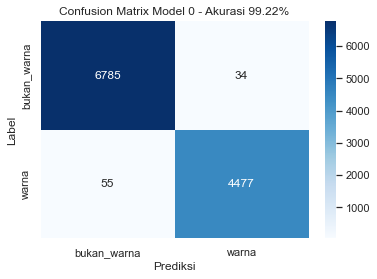

In [254]:
# Membuat confusion matrix untuk prediksi model_0
cf_matrix = confusion_matrix(test_target_mnb, pred_model_0)

# Menampilkan confusion matrix menggunakan seaborn
ax = sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')

ax.set_title(f'Confusion Matrix Model 0 - Akurasi {skor_model_0:.2%}')
ax.set_xlabel('Prediksi')
ax.set_ylabel('Label')

# label tick
ax.xaxis.set_ticklabels(['bukan_warna', 'warna'])
ax.yaxis.set_ticklabels(['bukan_warna', 'warna'])

# Tampilkan
plt.show()

Pada tabel *Confusion Matrix* di atas kita dapat melihat bahwa Model 0 berhasil memprediksi secara tepat 6,786 kata dengan label `bukan_warna` dan 4,477 kata dengan label `warna`.

Terdapat setidaknya 55 kata yang merupakan `warna` namun diprediksi oleh Model 0 sebagai `bukan_warna` dan 34 kata yang merupakan `bukan_warna` namun diprediksi oleh Model 0 sebagai `warna`

In [274]:
data_test = pd.DataFrame(test_data_mnb, columns=data_header)[['brand', 'kata', 'urut_kata', 'total_kata', 'label']]
data_pred = pd.DataFrame(np.int32(pred_model_0), columns=['prediksi'])
data_pred.iloc[:, 0].tolist()
data_test['prediksi'] = data_pred.iloc[:, 0].tolist()
data_test

,brand,kata,urut_kata,total_kata,label,prediksi
16829,ADI,SESOYE,5.0,6.0,warna,1
5081,ADI,GHOST,1.0,4.0,bukan_warna,0
22648,KIP,BLACK,2.0,5.0,warna,1
13440,ADI,FLEX,2.0,5.0,bukan_warna,0
38893,NIK,BLACK,7.0,10.0,warna,1
...,...,...,...,...,...,...
30083,NIK,BLACK,5.0,7.0,warna,1
35946,NIK,WHITE,9.0,9.0,warna,1
31049,NIK,WMNS,1.0,10.0,bukan_warna,0
53501,PUM,X,2.0,10.0,bukan_warna,0


In [275]:
# Set inverse dari label encoder
inverse_label_encoder = list(label_encoder.inverse_transform([0, 1]))
data_test = pd.DataFrame(test_data_mnb, columns=data_header)[['brand', 'kata', 'urut_kata', 'total_kata', 'label']]
data_pred = pd.DataFrame(np.int32(pred_model_0), columns=['prediksi'])
data_test['prediksi'] = data_pred.iloc[:, 0].tolist()
data_test['prediksi'] = data_test['prediksi'].astype(int).map(lambda x: inverse_label_encoder[x])
data_test = data_test.loc[data_test['label']!= data_test['prediksi']]
with pd.option_context('display.max_rows', None):
    display(data_test)


,brand,kata,urut_kata,total_kata,label,prediksi
55259,STN,AQUA,3.0,3.0,warna,bukan_warna
12,ADI,BASKETBALL,5.0,6.0,warna,bukan_warna
23355,NIC,7,11.0,11.0,warna,bukan_warna
56444,WAR,OREO,2.0,3.0,warna,bukan_warna
46960,NIK,FTR10PURE,2.0,7.0,warna,bukan_warna
13918,ADI,CARDBOARD,2.0,2.0,warna,bukan_warna
8735,ADI,FULL,1.0,3.0,bukan_warna,warna
31091,NIK,VIALEBLACK,2.0,4.0,warna,bukan_warna
51267,PUM,TRACE,2.0,7.0,bukan_warna,warna
5964,ADI,CLOUD,2.0,3.0,warna,bukan_warna


## Model 1: Conv1D dengan Embedding

`Conv1D` atau *1-dimension convolution* merupakan satu jenis layer dari layer convolution yang umumnya digunakan untuk mengekstrak fitur penting dari input data.

Meskipun umumnya jaringan saraf tiruan *convolution* digunakan untuk klasifikasi gambar (`Conv2D`) pada pembelajaran *image recognition*, tidak jarang juga `Conv1D` dipergunakan dalam *natural language processing* atau *time series forecasting*.

Layer ini pada prinsipnya menggunakan *kernel_size*, *padding* dan juga *stride* untuk menciptakan sebuah jendela yang akan men-*scan* input matrix atau vektor secara perlahan dan melakukan *pooling* (*min*, *max* atau *average pooling*) untuk mengekstrak nilai yang menjadi fitur penting dari input data.

<div>
<img src="gambar/convlayer.gif" width=300/>
</div>

*contoh `Conv2D` pada jaringan saraf tiruan untuk klasifikasi biner/multiclass dari input gambar*

Lebih lanjut mengenai jaringan saraf tiruan *convolution* (convolutional neural network) dapat merujuk pada [CNN Explainer](https://poloclub.github.io/cnn-explainer/)

### Vektorisasi dan Embedding Kata

#### Membuat Lapisan Vektorisasi Kata

Vektorisasi sebenarnya merupakan proses yang cukup sederhana yang merubah kata menjadi representasi numerik berdasarkan total jumlah kata dalam *vocabulary* dari input data.

Di lapisan vektorisasi ini sebenarnya kita melakukan beberapa proses pengolahan terhadap teks yang bersifat opsional, diantaranya:
* Standarisasi kata, merubah semua kata menjadi *lowercase* dan menghilangkan tanda baca (*punctuation*)
* Split setiap input teks menjadi per kata (untuk input yang berupa kalimat)
* Pembentukan *ngrams* pada *corpus*. Apa itu [*ngrams*](https://en.wikipedia.org/wiki/N-gram) dan [*text corpus*](https://en.wikipedia.org/wiki/Text_corpus).
* Indeksasi token (kata)
* Transformasi setiap input menggunakan indeksasi token untuk menghasilkan vektor integer atau vektor angka *float*

Sedangkan *embedding* adalah proses lebih lanjut setelah vektorisasi kata ke dalam representasi numerik. Pada dasarnya embedding adalah sebuah lapisan yang akan memberikan kemampuan untuk menyimpan bobot awal (*initial weight*) dan juga bobot yang nilainya akan di*update* selama proses *training* untuk kata dalam input data. 

Pada akhir proses training, bobot dari suatu kata sudah melalui beberapa ratus putaran *training* (*epoch*) dari jaringan saraf tiruan dan diharapkan sudah memiliki nilai yang lebih akurat untuk merepresentasikan keadaan (*state*) dari suatu kata terhadap kategori kata atau kalimat yang menjadi target dari proses *training*.

Lebih lengkapnya dapat merujuk pada link berikut:
- Lapisan Vektorisasi Teks: https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
- Lapisan Embedding Teks: https://www.tensorflow.org/text/guide/word_embeddings

In [276]:
train_data[:3]

,kata,urut_kata,total_kata,brand_ADI,brand_ADS,brand_AGL,brand_AND,brand_ASC,brand_BAL,brand_BBC,...,brand_PSB,brand_PTG,brand_PUM,brand_REL,brand_SAU,brand_SOC,brand_STN,brand_UME,brand_VAP,brand_WAR
43886,GREY,12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14859,BLACK,4.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47729,U,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [281]:
# jumlah data (kata) dalam train_data
print(f'jumlah data: {len(train_data.kata)}\n')
train_data.kata[:3]

jumlah data: 45400



43886     GREY
14859    BLACK
47729        U
Name: kata, dtype: object

In [282]:
# jumlah data unik (kata unik) dalam train_data[:, 0]
jumlah_kata_train = len(np.unique(train_data.kata))
jumlah_kata_train

2957

In [283]:
# Membuat lapisan vektorisasi kata
lapisan_vektorisasi = TextVectorization(max_tokens=jumlah_kata_train,
                                        output_sequence_length=1,
                                        standardize='lower_and_strip_punctuation',
                                        name='lapisan_vektorisasi')

In [332]:
# Mengadaptasikan lapisan vektorisasi ke dalam train_kata
lapisan_vektorisasi.adapt(train_data.kata.tolist())

In [331]:
# Uji vektorisasi kata
import random
target_kata = random.choice(train_data.kata.tolist())
print(f'Kata:\n{target_kata}\n')
print(f'Kata setelah vektorisasi:\n{lapisan_vektorisasi([target_kata])}')

Kata:
JOGGER

Kata setelah vektorisasi:
[[176]]


In [333]:
lapisan_vektorisasi.get_config()

{'name': 'lapisan_vektorisasi',
 'trainable': True,
 'batch_input_shape': (None, None),
 'dtype': 'string',
 'max_tokens': 2957,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 1,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [334]:
# Jumlah vocabulary dalam lapisan_vektorisasi
jumlah_vocab = lapisan_vektorisasi.get_vocabulary()
len(jumlah_vocab)

2906

#### Membuat Lapisan Text Embedding

In [335]:
# Membuat lapisan embedding kata
lapisan_embedding = Embedding(input_dim=len(jumlah_vocab),
                              output_dim=64,
                              mask_zero=True,
                              name='lapisan_embedding')

In [336]:
# Contoh vektorisasi dan embedding
print(f'Kata sebelum vektorisasi:\n{target_kata}\n')
kata_tervektor = lapisan_vektorisasi([target_kata])
print(f'\nKata sesudah vektorisasi (sebelum embedding):\n{kata_tervektor}\n')
kata_terembed = lapisan_embedding(kata_tervektor)
print(f'\nKata setelah embedding:\n{kata_terembed}\n')
print(f'Shape dari kata setelah embedding:\n{kata_terembed.shape}')

Kata sebelum vektorisasi:
JOGGER


Kata sesudah vektorisasi (sebelum embedding):
[[176]]


Kata setelah embedding:
[[[ 0.04620032  0.00651318  0.02343576  0.03251297 -0.02524682
   -0.03512342 -0.01226227  0.03698638 -0.04775412  0.04855115
   -0.0356064   0.04821995 -0.01183139  0.03249738  0.02402598
    0.0107192   0.02295447  0.03935916 -0.04284633  0.02972814
   -0.0420555  -0.03330634  0.01502011 -0.01877768  0.02598813
   -0.04269612  0.04789175  0.00637921 -0.02723283  0.04458461
    0.03665339 -0.01673269  0.04518887 -0.00630584  0.04658565
   -0.01743253 -0.00691651 -0.03493007  0.02605814 -0.00439446
    0.03842232 -0.01316901  0.00552486 -0.01493831  0.04643793
   -0.04652617 -0.02129012  0.01651739  0.02055892  0.03733995
   -0.0295748  -0.0056739  -0.04857774  0.00764843 -0.03197213
    0.03090907  0.02329891  0.00123161 -0.04582451  0.02079279
   -0.03908415 -0.00573503  0.01018824 -0.0039709 ]]]

Shape dari kata setelah embedding:
(1, 1, 64)


### Membuat TensorFlow Dataset, Batching dan Prefetching

Pada bagian ini kita akan merubah data menjadi *dataset* dan menerapkan *batching* serta *prefetching* pada dataset untuk mempercepat performa *training* model.

<div>
<img src="gambar/prefetched.jpg" width=700/>
</div>

Lihat https://www.tensorflow.org/guide/data_performance

In [366]:
# Membuat TensorFlow dataset
train_kata_dataset = from_tensor_slices((train_data.iloc[:, 0], train_target))
test_kata_dataset = from_tensor_slices((test_data.iloc[:, 0], test_target))
train_posisi_kata_dataset = from_tensor_slices(((train_data.iloc[:, 1:3].to_numpy()), train_target))
test_posisi_kata_dataset = from_tensor_slices(((test_data.iloc[:, 1:3].to_numpy()), test_target))
train_brand_kata_dataset = from_tensor_slices(((train_data.iloc[:, 3:].to_numpy()), train_target))
test_brand_kata_dataset = from_tensor_slices(((test_data.iloc[:, 3:].to_numpy()), test_target))

train_kata_dataset, test_kata_dataset, train_posisi_kata_dataset, test_posisi_kata_dataset, train_brand_kata_dataset, test_brand_kata_dataset

(<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>,
 <TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>,
 <TensorSliceDataset element_spec=(TensorSpec(shape=(2,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>,
 <TensorSliceDataset element_spec=(TensorSpec(shape=(2,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>,
 <TensorSliceDataset element_spec=(TensorSpec(shape=(37,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>,
 <TensorSliceDataset element_spec=(TensorSpec(shape=(37,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>)

In [369]:
# Membuat TensorSliceDataset menjadi prefetched dataset
train_kata_dataset = train_kata_dataset.batch(UKURAN_BATCH).prefetch(tf.data.AUTOTUNE)
test_kata_dataset = test_kata_dataset.batch(UKURAN_BATCH).prefetch(tf.data.AUTOTUNE)
train_posisi_kata_dataset = train_posisi_kata_dataset.batch(UKURAN_BATCH).prefetch(tf.data.AUTOTUNE)
test_posisi_kata_dataset = test_posisi_kata_dataset.batch(UKURAN_BATCH).prefetch(tf.data.AUTOTUNE)
train_brand_kata_dataset = train_brand_kata_dataset.batch(UKURAN_BATCH).prefetch(tf.data.AUTOTUNE)
test_brand_kata_dataset = test_brand_kata_dataset.batch(UKURAN_BATCH).prefetch(tf.data.AUTOTUNE)

train_kata_dataset, test_kata_dataset, train_posisi_kata_dataset, test_posisi_kata_dataset, train_brand_kata_dataset, test_brand_kata_dataset

(<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 37), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 37), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

### Membangun dan menjalankan training Model 1

In [374]:
# Membuat model_1 dengan layer Conv1D dan lapisan vektorisasi serta embedding input kata
inputs = Input(shape=(1,), 
               dtype=tf.string, 
               name='lapisan_input')
lapisan_vektorisasi = lapisan_vektorisasi(inputs)
lapisan_embed = lapisan_embedding(lapisan_vektorisasi)
x = Conv1D(filters=64, 
           kernel_size=5, 
           padding='same', 
           activation='relu',
           name='lapisan_konvolusional_1_dimensi')(lapisan_embed)
x = GlobalMaxPooling1D(name='lapisan_max_pool')(x)
outputs = Dense(units=1, 
                activation='sigmoid', 
                name='lapisan_output')(x)
model_1 = Model(inputs=inputs, 
                outputs=outputs, 
                name='model_1_Conv1D_vektorisasi_embedding')

# Compile
model_1.compile(loss=BinaryCrossentropy(),
                optimizer=Adam(),
                metrics=['accuracy'])

In [375]:
# Ringkasan dari model_1
model_1.summary()

Model: "model_1_Conv1D_vektorisasi_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lapisan_input (InputLayer)  [(None, 1)]               0         
                                                                 
 lapisan_vektorisasi (TextVe  (None, 1)                0         
 ctorization)                                                    
                                                                 
 lapisan_embedding (Embeddin  (None, 1, 64)            185984    
 g)                                                              
                                                                 
 lapisan_konvolusional_1_dim  (None, 1, 64)            20544     
 ensi (Conv1D)                                                   
                                                                 
 lapisan_max_pool (GlobalMax  (None, 64)               0         
 Pooling1D)                   

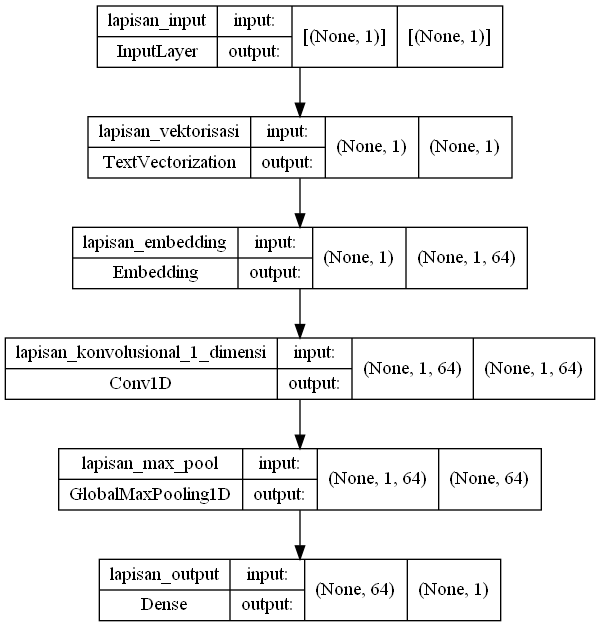

In [376]:
# Plot model_1
from tensorflow.keras.utils import plot_model # type: ignore
plot_model(model_1, show_shapes=True)

In [379]:
# Setup wandb init dan config
wb.init(project=wandb['proyek'],
        entity=wandb['user'],
        name=model_1.name,
        config={'epochs': EPOCHS,
                'n_layers': len(model_1.layers)})

# Fit model_1
model_1.fit(train_kata_dataset,
            epochs=wb.config.epochs,
            validation_data=test_kata_dataset,
            callbacks=[wandb_callback(),
                       model_checkpoint(model_1.name),
                       early_stopping(),
                       reduce_lr_on_plateau()])

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Epoch 1/1000
710/710 [==============================] - ETA: 0s - loss: 0.0977 - accuracy: 0.9830

wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.


INFO:tensorflow:Assets written to: d:\ColorSkim\wandb\run-20220719_164202-pdrwgego\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ColorSkim\wandb\run-20220719_164202-pdrwgego\files\model-best\assets
wandb: Adding directory to artifact (d:\ColorSkim\wandb\run-20220719_164202-pdrwgego\files\model-best)... Done. 0.7s


INFO:tensorflow:Assets written to: colorskim_checkpoint\model_1_Conv1D_vektorisasi_embedding\assets


INFO:tensorflow:Assets written to: colorskim_checkpoint\model_1_Conv1D_vektorisasi_embedding\assets


710/710 [==============================] - 95s 121ms/step - loss: 0.0977 - accuracy: 0.9830 - val_loss: 0.0304 - val_accuracy: 0.9912 - _timestamp: 1658223812.0000 - _runtime: 84.0000 - lr: 0.0010
Epoch 2/1000
710/710 [==============================] - 63s 89ms/step - loss: 0.0180 - accuracy: 0.9952 - val_loss: 0.0306 - val_accuracy: 0.9904 - _timestamp: 1658223894.0000 - _runtime: 166.0000 - lr: 0.0010
Epoch 3/1000
710/710 [==============================] - ETA: 0s - loss: 0.0154 - accuracy: 0.9960

INFO:tensorflow:Assets written to: d:\ColorSkim\wandb\run-20220719_164202-pdrwgego\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ColorSkim\wandb\run-20220719_164202-pdrwgego\files\model-best\assets
wandb: Adding directory to artifact (d:\ColorSkim\wandb\run-20220719_164202-pdrwgego\files\model-best)... Done. 0.2s


INFO:tensorflow:Assets written to: colorskim_checkpoint\model_1_Conv1D_vektorisasi_embedding\assets


INFO:tensorflow:Assets written to: colorskim_checkpoint\model_1_Conv1D_vektorisasi_embedding\assets


710/710 [==============================] - 69s 97ms/step - loss: 0.0154 - accuracy: 0.9960 - val_loss: 0.0299 - val_accuracy: 0.9913 - _timestamp: 1658223954.0000 - _runtime: 226.0000 - lr: 0.0010
Epoch 4/1000
710/710 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.9962

INFO:tensorflow:Assets written to: d:\ColorSkim\wandb\run-20220719_164202-pdrwgego\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ColorSkim\wandb\run-20220719_164202-pdrwgego\files\model-best\assets
wandb: Adding directory to artifact (d:\ColorSkim\wandb\run-20220719_164202-pdrwgego\files\model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: colorskim_checkpoint\model_1_Conv1D_vektorisasi_embedding\assets


INFO:tensorflow:Assets written to: colorskim_checkpoint\model_1_Conv1D_vektorisasi_embedding\assets


710/710 [==============================] - 69s 98ms/step - loss: 0.0146 - accuracy: 0.9962 - val_loss: 0.0297 - val_accuracy: 0.9922 - _timestamp: 1658224024.0000 - _runtime: 296.0000 - lr: 0.0010
Epoch 5/1000
710/710 [==============================] - 62s 87ms/step - loss: 0.0143 - accuracy: 0.9962 - val_loss: 0.0299 - val_accuracy: 0.9922 - _timestamp: 1658224094.0000 - _runtime: 366.0000 - lr: 0.0010
Epoch 6/1000
710/710 [==============================] - 60s 84ms/step - loss: 0.0140 - accuracy: 0.9963 - val_loss: 0.0301 - val_accuracy: 0.9922 - _timestamp: 1658224154.0000 - _runtime: 426.0000 - lr: 0.0010
Epoch 7/1000
710/710 [==============================] - 61s 86ms/step - loss: 0.0138 - accuracy: 0.9963 - val_loss: 0.0302 - val_accuracy: 0.9922 - _timestamp: 1658224215.0000 - _runtime: 487.0000 - lr: 0.0010
Epoch 8/1000
710/710 [==============================] - 59s 83ms/step - loss: 0.0136 - accuracy: 0.9964 - val_loss: 0.0305 - val_accuracy: 0.9922 - _timestamp: 1658224273.00

KeyboardInterrupt: 

In [29]:
# Evaluasi model_1
model_1.evaluate(test_dataset)

887/887 [==============================] - 45s 51ms/step - loss: 0.0303 - accuracy: 0.9926


[0.03030860796570778, 0.9925641417503357]

In [30]:
# Membuat prediksi berdasarkan model_1
model_1_pred_prob = model_1.predict(test_dataset)
model_1_pred_prob[:10]

array([[5.1793031e-05],
       [6.5180029e-05],
       [8.7126767e-07],
       [9.9771899e-01],
       [9.9969602e-01],
       [2.4920701e-06],
       [2.1196477e-04],
       [2.2293185e-03],
       [1.2963725e-04],
       [9.9663699e-01]], dtype=float32)

In [31]:
# Mengkonversi model_1_pred_prob ke dalam label
model_1_pred = tf.squeeze(tf.round(model_1_pred_prob))
model_1_pred

<tf.Tensor: shape=(28376,), dtype=float32, numpy=array([0., 0., 0., ..., 1., 0., 1.], dtype=float32)>

In [32]:
# Menghitung metriks dari model_1
model_1_metrik = hitung_metrik(target=test_label_encode,
                              prediksi=model_1_pred)
model_1_metrik

{'akurasi': 0.9925641387087679,
 'presisi': 0.9925790596107587,
 'recall': 0.9925641387087679,
 'f1-score': 0.9925584581306051}

## Model 2: Transfer Learning pretrained feature exraction menggunakan Universal Sentence Encoder (USE)

In [34]:
# Download pretrained USE
import tensorflow_hub as hub
tf_hub_embedding = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                  trainable=False,
                                  name='universal_sentence_encoder')

In [35]:
# Melakukan tes pretrained embedding pada contoh kata
kata_acak = random.choice(train_kata)
print(f'Kata acak:\n {kata_acak}')
kata_embed_pretrain = tf_hub_embedding([kata_acak])
print(f'\nKata setelah embed dengan USE:\n{kata_embed_pretrain[0][:30]}\n')
print(f'Panjang dari kata setelah embedding: {len(kata_embed_pretrain[0])}')

Kata acak:
 QUESTAR

Kata setelah embed dengan USE:
[ 0.00866413 -0.06154143  0.05114514  0.04181407  0.0199904   0.05046864
 -0.01953758 -0.05738599  0.06517273 -0.00517753  0.00351421  0.02564281
  0.02964722  0.06797459 -0.00300142  0.0053544  -0.00830155 -0.03211842
  0.04801427 -0.00119406 -0.00043531  0.01120288  0.04401749 -0.01213133
 -0.00378824  0.04055084 -0.01255467  0.02171156  0.05214996  0.01138981]

Panjang dari kata setelah embedding: 512


In [36]:
# Membuat model_2 menggunakan USE
inputs = layers.Input(shape=[], dtype=tf.string, name='layer_input')
layer_embed_pretrained = tf_hub_embedding(inputs)
x = layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(tf.expand_dims(layer_embed_pretrained, axis=-1))
x = layers.GlobalMaxPooling1D(name='layer_max_pooling')(x)
outputs = layers.Dense(1, activation='sigmoid', name='layer_output')(x)
model_2 = tf.keras.Model(inputs=inputs, outputs=outputs, name='model_2_Conv1D_USE_embed')

In [37]:
# Ringkasan model_2
model_2.summary()

Model: "model_2_Conv1D_USE_embed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_input (InputLayer)    [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 512, 1)           0         
                                                                 
 conv1d (Conv1D)             (None, 512, 64)           384       
                                                                 
 layer_max_pooling (GlobalMa  (None, 64)               0         
 xPooling1D)                                                     
                                                                 
 layer_output (Dense)        (None, 1)    

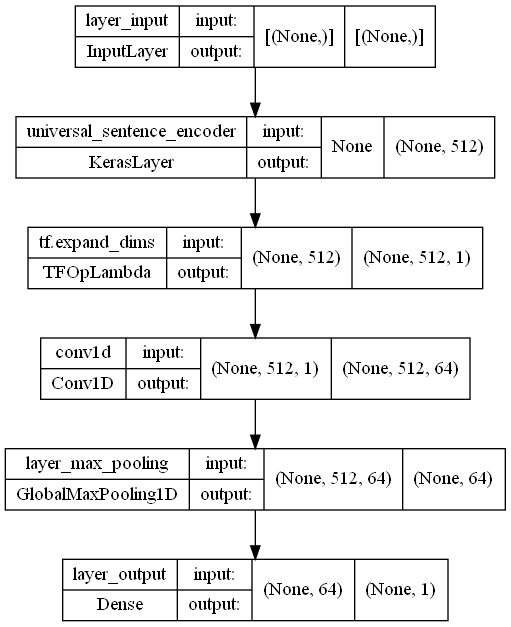

In [38]:
# Plot model_2
plot_model(model_2, show_shapes=True)

In [39]:
# Compile model_2
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [40]:
# Setup wandb init dan config
wb.init(project='ColorSkim',
        entity='jpao',
        name='model_2_Conv1D_USE_embed',
        config={'epochs': 3,
                'n_layers': len(model_2.layers)})

# Fit model_2
hist_model_2 = model_2.fit(train_dataset,
                           epochs=wb.config.epochs,
                           validation_data=test_dataset,
                           callbacks=[WandbCallback()])

accuracy,▁██
epoch,▁▅█
loss,█▁▁
val_accuracy,▁▆█
val_loss,█▁▂
GFLOPS,0.0
accuracy,0.99556
best_epoch,1
best_val_loss,0.03002
epoch,2
loss,0.01627


wandb: WARNING Unable to compute FLOPs for this model.


Epoch 1/3
887/887 [==============================] - 226s 246ms/step - loss: 0.6405 - accuracy: 0.6114 - val_loss: 0.5905 - val_accuracy: 0.8387 - _timestamp: 1657516765.0000 - _runtime: 297.0000
Epoch 2/3
887/887 [==============================] - 219s 247ms/step - loss: 0.5211 - accuracy: 0.8137 - val_loss: 0.4554 - val_accuracy: 0.8914 - _timestamp: 1657516982.0000 - _runtime: 514.0000
Epoch 3/3
887/887 [==============================] - 228s 257ms/step - loss: 0.4021 - accuracy: 0.8879 - val_loss: 0.3575 - val_accuracy: 0.9052 - _timestamp: 1657517211.0000 - _runtime: 743.0000


In [41]:
# Evaluate model_2
model_2.evaluate(test_dataset)

887/887 [==============================] - 67s 76ms/step - loss: 0.3575 - accuracy: 0.9052


[0.3574761152267456, 0.9051663279533386]

In [42]:
# Membuat prediksi dengan model_2
model_2_pred_prob = model_2.predict(test_dataset)
model_2_pred_prob[:10]

array([[0.16605161],
       [0.15431982],
       [0.20437935],
       [0.6168258 ],
       [0.8310257 ],
       [0.19871134],
       [0.21265136],
       [0.17426637],
       [0.1890059 ],
       [0.4124583 ]], dtype=float32)

In [43]:
# Mengkonversi model_2 menjadi label format
model_2_pred = tf.squeeze(tf.round(model_2_pred_prob))
model_2_pred

<tf.Tensor: shape=(28376,), dtype=float32, numpy=array([0., 0., 0., ..., 1., 0., 1.], dtype=float32)>

In [44]:
# Menghitung hasil metrik dari model_2
model_2_hasil = hitung_metrik(target=test_label_encode,
                              prediksi=model_2_pred)
model_2_hasil

{'akurasi': 0.9051663377502115,
 'presisi': 0.9052541793259783,
 'recall': 0.9051663377502115,
 'f1-score': 0.9045830735846138}

## Model 3: Menggunakan positional kata dan custom embed dan concatenate layer

In [45]:
# Test prediksi dengan model_1 (model_1_Conv1D_embed)
class_list = ['bukan_warna', 'warna']
article = 'PUMA XTG WOVEN PANTS PUMA BLACK-PUMA WHITE'
article_list = article.replace("-"," ").split()
model_test = tf.squeeze(tf.round(model_1.predict(article.replace("-"," ").split())))
for i in range(0, len(article_list)):
    print(f'Kata: {article_list[i]}\nPrediksi: {class_list[int(model_test[i])]}\n\n')

Kata: PUMA
Prediksi: bukan_warna


Kata: XTG
Prediksi: bukan_warna


Kata: WOVEN
Prediksi: bukan_warna


Kata: PANTS
Prediksi: bukan_warna


Kata: PUMA
Prediksi: bukan_warna


Kata: BLACK
Prediksi: warna


Kata: PUMA
Prediksi: bukan_warna


Kata: WHITE
Prediksi: warna




In [46]:
model_test

<tf.Tensor: shape=(8,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1., 0., 1.], dtype=float32)>